In [1]:
import os
import sys
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

In [20]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',    
    'img_size_h': 235,
    'img_size_w': 80,
    'img_size': 512,
    'epochs': 10,
    'train_bs': 128,
    'valid_bs': 256,
    'lr': 1e-4,
    'num_workers': 4,
    'accum_iter': 1, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'tta': 3,
    'used_epochs': [5,6,7,8],
    'prob_thres':[0.1,0.08, 0.06, 0.04, 0.02, 0.01],
    'weights': [1,1,1,1]
}

In [3]:
train_with_misc = pd.read_csv("../input/gala-images-classification/dataset/train.csv")
# misc は特殊なものとして扱う
train_with_misc["is_misc"] = (train_with_misc["Class"]=="misc")*1
label_dic = {"Attire":0, "Food":1, "Decorationandsignage":2,"misc":3}
train_with_misc["label"]=train_with_misc["Class"].map(label_dic)
train_with_misc.head()

,Image,Class,is_misc,label
0,image4.jpg,Attire,0,0
1,image7.jpg,misc,1,3
2,image10.jpg,Food,0,1
3,image11.jpg,Decorationandsignage,0,2
4,image13.jpg,Decorationandsignage,0,2


In [4]:
submission = pd.read_csv("../input/gala-images-classification/dataset/sample_submission.csv", index_col=0)
submission.head()

,Image,Class
0,image9000.jpg,Food
1,image9001.jpg,Food
2,image9003.jpg,Food
3,image9007.jpg,Food
4,image9008.jpg,Food


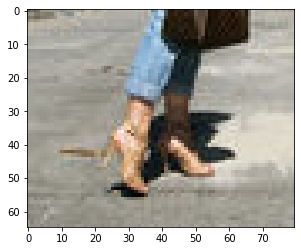

In [5]:
def seed_everything(seed):
    "seed値を一括指定"
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    """
    pathからimageの配列を得る
    """
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('../input/gala-images-classification/dataset/Train_Images/image4.jpg')
plt.imshow(img)
plt.show()

In [6]:
def rand_bbox(size, lam):
    """
    ランダムなボックスを出力する
    lam の大きさに従って、ランダムな位置でカットした正方形を出力する。はみ出たらクリップしてカット
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

class GalaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size_h'], CFG['img_size_w']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 },
                 image_name_col = "Image",
                 label_col = "label"
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        self.image_name_col = image_name_col
        self.label_col = label_col
        
        if output_label == True:
            self.labels = self.df[self.label_col].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df[self.label_col].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index][self.image_name_col]))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix][self.image_name_col]))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size_h']/CFG['img_size_w']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size_h'], CFG['img_size_w']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size_h'] * CFG['img_size_w']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

In [7]:
# transform
"""
大きさは、ひとまず縦235,横80の値にそろえるために、resize ではなく PadIfNeeded にする
"""


from albumentations import (
    PadIfNeeded, HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            PadIfNeeded(CFG['img_size_h'], CFG['img_size_w']),
            #RandomResizedCrop(CFG['img_size_h'], CFG['img_size_w']),
            #Transpose(p=0.5), # サイズを正方形にしないといけない
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            PadIfNeeded(CFG['img_size_h'], CFG['img_size_w']),
            #CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size_h'], CFG['img_size_w']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

def get_inference_transforms():
    return Compose([
            PadIfNeeded(CFG['img_size_h'], CFG['img_size_w']),
            #RandomResizedCrop(CFG['img_size_h'], CFG['img_size_w']),
            #Transpose(p=0.5), # サイズを正方形にしないといけない
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [8]:
class GalaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## main

In [9]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [33]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch
        
    train = train_with_misc

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        if fold > 0:
            break 

        print('Inference fold {} started'.format(fold))

        valid_ = train.loc[val_idx,:].reset_index(drop=True)
        valid_ds = GalaDataset(valid_, '../input/gala-images-classification/dataset/Train_Images', transforms=get_inference_transforms(), output_label=False)
        
        test = pd.DataFrame()
        test['Image'] = list(os.listdir('../input/gala-images-classification/dataset/Test_Images'))
        test_ds = GalaDataset(test, '../input/gala-images-classification/dataset/Test_Images', transforms=get_inference_transforms(), output_label=False)
        
        val_loader = torch.utils.data.DataLoader(
            valid_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=False,
        )
        
        tst_loader = torch.utils.data.DataLoader(
            test_ds, 
            batch_size=CFG['valid_bs'],
            num_workers=CFG['num_workers'],
            shuffle=False,
            pin_memory=False,
        )

        device = torch.device(CFG['device'])
        #model = GalaImgClassifier(CFG['model_arch'], train.label.nunique()).to(device)
        model = GalaImgClassifier(CFG['model_arch'], train.label.nunique()-1).to(device) # misc を除いた
        
        val_preds = []
        tst_preds = []
        
        #for epoch in range(CFG['epochs']-3):
        for i, epoch in enumerate(CFG['used_epochs']):    
            model.load_state_dict(torch.load('save/{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch)))
            
            with torch.no_grad():
                for _ in range(CFG['tta']):
                    val_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, val_loader, device)]
                    tst_preds += [CFG['weights'][i]/sum(CFG['weights'])/CFG['tta']*inference_one_epoch(model, tst_loader, device)]

        val_preds = np.mean(val_preds, axis=0) 
        tst_preds = np.mean(tst_preds, axis=0) 
        
        # misc を除いたときの validation loss をみる
        indx = valid_["Class"]!="misc"
        print('fold {} no misc validation loss = {:.5f}'.format(fold, log_loss(valid_.label.values[indx], val_preds[indx])))
        print('fold {} no misc validation accuracy = {:.5f}'.format(fold, (valid_.label.values[indx]==np.argmax(val_preds[indx], axis=1)).mean()))
        # 閾値ごとの正答率をみる
        for p in CFG["prob_thres"]:
            label_preds = np.argmax(val_preds, axis=1)
            label_preds[val_preds.max(axis=1)<p] = 3
            print('fold {} (p={}) validation accuracy = {:.5f}'.format(fold,p,(valid_.label.values==label_preds).mean()))
        
        del model
        torch.cuda.empty_cache()

Inference fold 0 started


100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


fold 0 no misc validation loss = 0.34752
fold 0 no misc validation accuracy = 0.88441
fold 0 (p=0.1) validation accuracy = 0.21602
fold 0 (p=0.08) validation accuracy = 0.33614
fold 0 (p=0.06) validation accuracy = 0.67123
fold 0 (p=0.04) validation accuracy = 0.71233
fold 0 (p=0.02) validation accuracy = 0.69336
fold 0 (p=0.01) validation accuracy = 0.69336


In [40]:
# 閾値を設定すること！！！
p = 0.04
test['Class'] = np.argmax(tst_preds, axis=1)
test.loc[tst_preds.max(axis=1)<p, 'Class'] = 3
label_dic = {0:"Attire", 1:"Food", 2:"Decorationandsignage",3:"misc"}
test["Class"]=test["Class"].map(label_dic)
test.head()

,Image,Class
0,image9103.jpg,Attire
1,image10310.jpg,Food
2,image9007.jpg,Food
3,image10582.jpg,Decorationandsignage
4,image9433.jpg,Attire


<AxesSubplot:xlabel='Class', ylabel='count'>

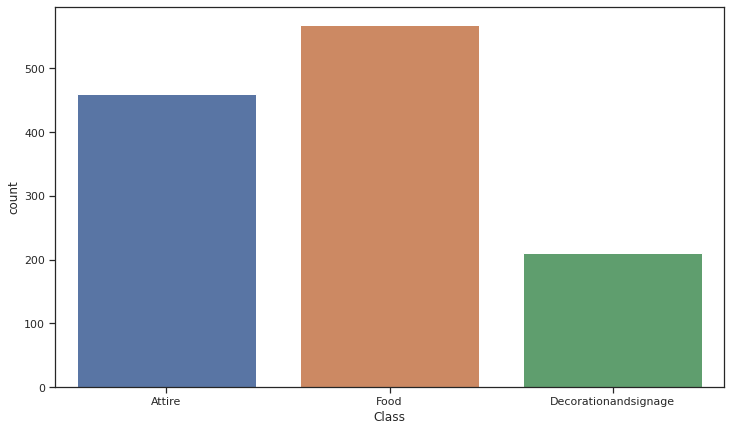

In [42]:
test.to_csv('submission.csv', index=False)